In [20]:
import tensorflow as tf
import keras
import requests
import cv2
import os
import numpy as np
import skimage
import matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
class_indices = {0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'Tomato___Leaf_Mold', 32: 'Tomato___Septoria_leaf_spot', 33: 'Tomato___Spider_mites Two-spotted_spider_mite', 34: 'Tomato___Target_Spot', 35: 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 36: 'Tomato___Tomato_mosaic_virus', 37: 'Tomato___healthy'}

In [15]:
curr_w_dir = os.getcwd()
img_base='leaf-fungus.png'
img_path = os.path.join(curr_w_dir, img_base)

url = " https://www.notcutts.co.uk/wordpress/wp-content/uploads/2018/11/fungal-leaf-spot.jpg"
# Fetch the image from the URL
response = requests.get(url)

# Convert the image to a numpy array
image_array = np.frombuffer(response.content, np.uint8)

# Decode the image array to OpenCV format
image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

image = cv2.resize(image,(256,256))
IMAGE_TEST = image
# # Now you can use the image with OpenCV functions
cv2.imwrite(img_path, image)

True

In [12]:
loaded_model_xception = keras.models.load_model('/Users/danielthorne/pdd-test/prediction-api/prediction-model/plant_disease_cnn_model_xception.h5')

In [18]:
# Function to preprocess a single image
def preprocess_image(image_path):
    image = skimage.io.imread(image_path)
    image_array = np.array(image) / 255.0  # Normalize to [0,1]
    return np.expand_dims(image_array, axis=0)  # Add batch dimension

In [19]:
img_size = (256, 256)
predictions = loaded_model_xception.predict(preprocess_image(img_path))
print(predictions[0])
predicted_class = np.argmax( predictions, axis=1)[0]
top_5_predicted_class = np.argsort(predictions[0])[-5:][::-1]
predicted_class_explicit = [ class_indices[p_class] for p_class in top_5_predicted_class]
print(f" The list of potential classes are : ")
predicted_class_explicit

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
[5.8860861e-04 4.8790528e-03 1.0115963e-05 8.2681247e-08 3.3332412e-10
 1.2103921e-05 9.8948345e-05 3.3344133e-04 1.2951687e-03 2.0308043e-04
 3.2331820e-06 7.1392082e-02 1.6900467e-03 8.6339889e-03 3.7720234e-05
 9.5069961e-09 2.9005946e-06 1.6014151e-07 3.0967662e-05 3.0151605e-06
 4.5153199e-04 8.5523288e-07 2.8951214e-05 3.3932161e-02 1.5079355e-05
 6.3020634e-05 5.3737241e-01 1.5524121e-04 2.9875108e-04 2.0833617e-01
 8.5443474e-02 1.0583639e-05 3.0585300e-04 1.9843036e-07 4.4158056e-02
 3.0433286e-05 1.7449012e-04 7.9847523e-06]
 The list of potential classes are : 


['Strawberry___Leaf_scorch',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Grape___Black_rot',
 'Tomato___Target_Spot']

<Functional name=functional, built=True>
tf.Tensor(26, shape=(), dtype=int64)


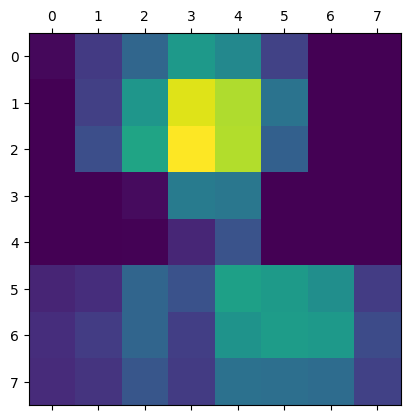

In [21]:

model = loaded_model_xception
# inputs = model.inputs
# outputs = model(inputs)
# redefined_model = tf.keras.Model(inputs=inputs, outputs=outputs) 
grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer("block14_sepconv2_act").output, model.output]
)
print(grad_model)
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(preprocess_image(img_path))
    
    pred_index = tf.argmax(preds[0])
    print(pred_index)
    class_channel = preds[ : ,pred_index]
grads = tape.gradient(class_channel, last_conv_layer_output)
# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
plt.matshow(heatmap.numpy())
plt.show()